In [1]:
from templates import *

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: saranga7. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /users/biocomp/mahanta/.netrc


#### Use in branch saranga2

In [2]:
device = 'cuda:1'
conf = ffhq128_autoenc_w_classifier()
conf.include_classifier = True
# conf.name = 'ffhq128_autoenc_w_classifier_weightedLoss_step_BN'
conf.name = 'ffhq128_w_integratedclassifier'
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device)
model.model.eval()
model.model.to(device)

Global seed set to 0


Classifier path: checkpoints/classifier/FFHQ_Gender.pth


Using cache found in /users/biocomp/mahanta/.cache/torch/hub/pytorch_vision_v0.10.0


Including classifier in the model
Model params: 124.71 M


BeatGANsAutoencModel(
  (time_embed): TimeStyleSeperateEmbed(
    (time_embed): Sequential(
      (0): Linear(in_features=128, out_features=512, bias=True)
      (1): SiLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
    (style): Identity()
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (cond_emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=128, bias

In [3]:
data = ImageDataset('imgs_align', image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
batch = data[1]['img'][None]

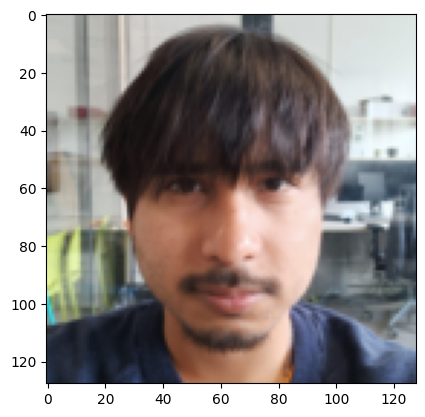

In [4]:
import matplotlib.pyplot as plt
plt.imshow(batch[0].permute([1, 2, 0]) / 2 + 0.5)

# Encode

In [7]:
cond = model.encode(batch.to(device), mode = 'non_ema', include_classifier=True)
xT = model.encode_stochastic(batch.to(device), cond, T=100, mode = 'non_ema')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.086747..6.790718].


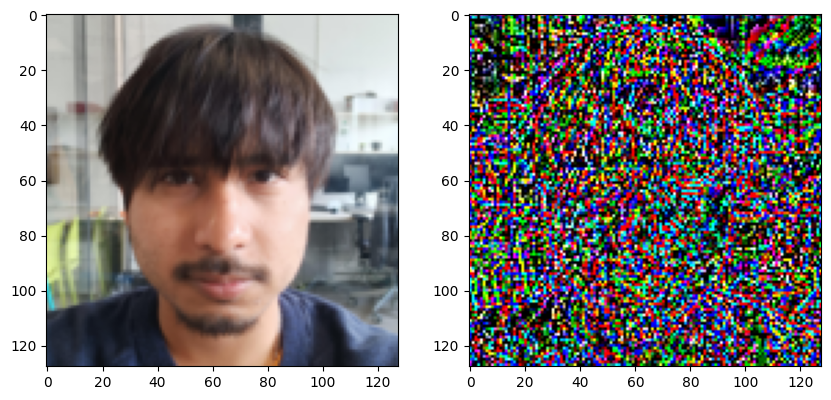

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(xT[0].permute(1, 2, 0).cpu())

# Decode

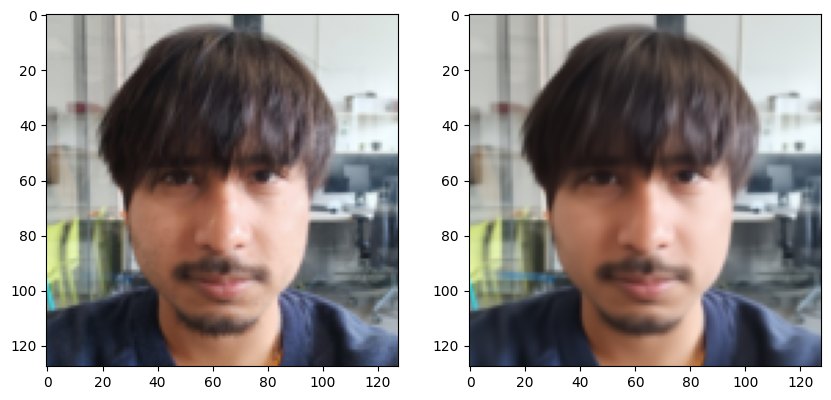

In [9]:
pred = model.render(xT, cond, T=100, mode = 'non_ema')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

In [10]:
random_XT = torch.randn_like(xT)

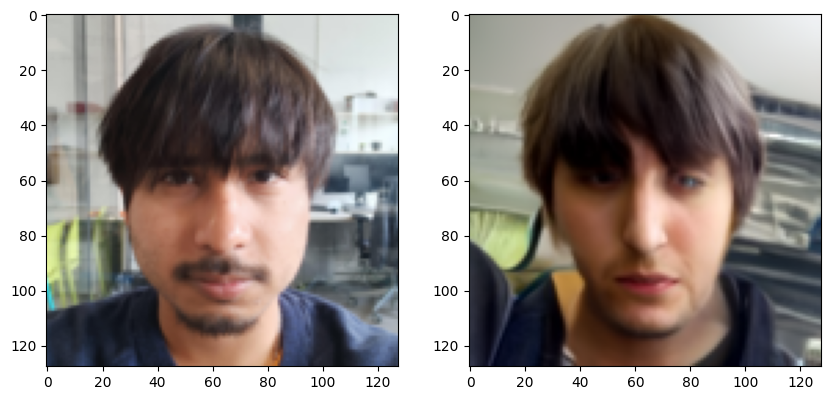

In [11]:
pred = model.render(random_XT, cond, T=100, mode = 'non_ema')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())

In [12]:
c = model.model.classifier_component(batch.to(device))
c

tensor([[0.5058, 0.4942]], device='cuda:1')

In [13]:
def encode(model, x, classifier_output, mode = 'ema'):
        # TODO:
        if mode == 'ema':
            model = model.ema_model
        else:
            model = model.model

        # Conditioning classifier specific information too now
        if classifier_output is not None:
            cond = model.encoder.forward(x, classifier_output = classifier_output)
        else:
            cond = model.encoder.forward(x, classifier_output = None)
        return cond

In [14]:
cond = encode(model, batch.to(device), classifier_output = torch.tensor([1, 0], dtype=torch.float).to(device), mode = 'non_ema')

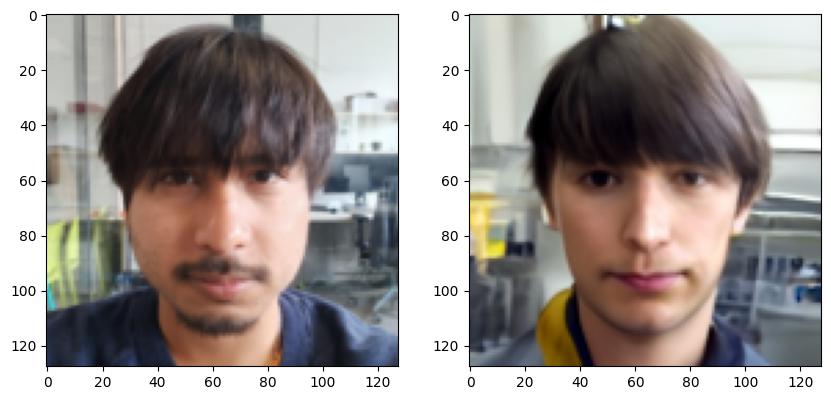

In [15]:
random_XT = torch.randn_like(xT)
pred = model.render(random_XT, cond, T=100, mode = 'non_ema')
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ori = (batch + 1) / 2
ax[0].imshow(ori[0].permute(1, 2, 0).cpu())
ax[1].imshow(pred[0].permute(1, 2, 0).cpu())